In [187]:
# Импорт библиотек

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

In [188]:
# Загружаем датасет
df = pd.read_csv('data/train.csv')

# Приводим даты к формату datetime и сортируем
df['dt'] = pd.to_datetime(df['dt'])
df = df.sort_values('dt')

In [189]:
# --- Добавляем временные признаки ---
df['year'] = df['dt'].dt.year  # Год
df['month'] = df['dt'].dt.month  # Месяц
df['week_of_year'] = df['dt'].dt.isocalendar().week  # Номер недели
df['quarter'] = df['dt'].dt.quarter  # Квартал

# Сезонные признаки (синус и косинус для месяца)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Создаем лаги и скользящие
for lag in [1, 2, 4, 8, 12]:
    df[f'lag_{lag}'] = df['pfr'].shift(lag)
df['rolling_mean_4'] = df['pfr'].rolling(window=4, min_periods=1).mean()
# Убираем NaN
df.dropna(inplace=True)

# Разделяем данные на train/test
train_size = int(len(df) * 0.85)
train, test = df.iloc[:train_size].copy(), df.iloc[train_size:].copy()

In [ ]:
# Определяем признаки и целевую переменную
features = [col for col in df.columns if 'lag' in col or 'rolling' in col or col in ['year', 'month', 'week_of_year', 'quarter', 'month_sin', 'month_cos']]
X_train, y_train = train[features], train['pfr']
X_test, y_test = test[features], test['pfr']

# Обучаем модель
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [191]:
# Предсказания
predictions = model.predict(X_test)

# Метрики
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
smape = np.mean(2 * np.abs(predictions - y_test) / (np.abs(y_test) + np.abs(predictions))) * 100

# Выводим метрики
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")

R²: 0.9872
MSE: 1358246.26
RMSE: 1165.44
MAE: 818.09
MAPE: 1.32%
SMAPE: 1.32%


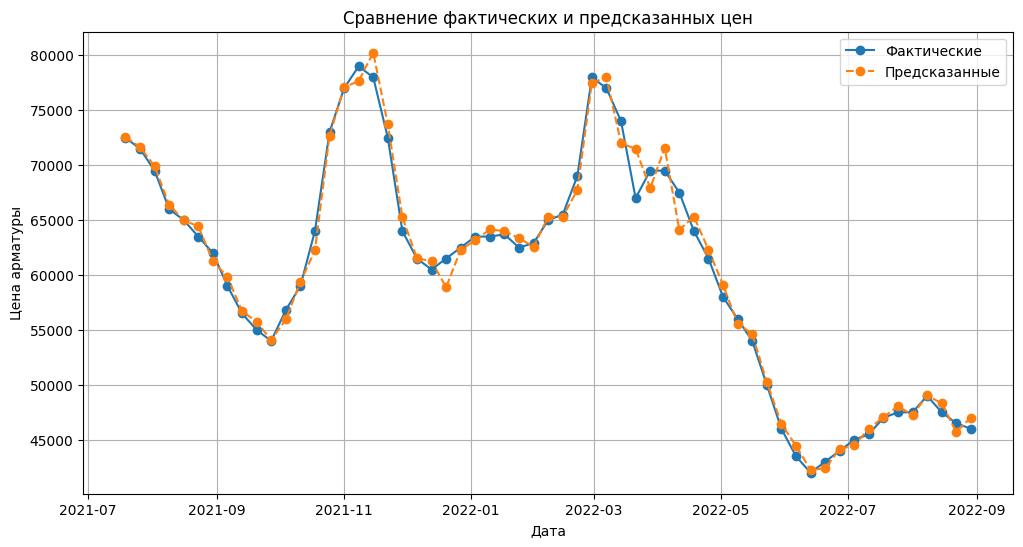

In [192]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test['dt'], y_test, label='Фактические', marker='o')
plt.plot(test['dt'], predictions, label='Предсказанные', linestyle='dashed', marker='o')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Цена арматуры')
plt.title('Сравнение фактических и предсказанных цен')
plt.grid()
plt.show()